## Requirements

In [1]:
# Import libraries
## Data
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import scipy.stats as st

## Preprocessing
### Data preprocessing
from geopy.distance import distance
from sklearn.preprocessing import MinMaxScaler
import requests
### Bert transformer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
### Datetime
from suntime import Sun 
from datetime import datetime, timedelta
from dateutil import tz
import time

## Clustering
### Clustering index
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import kneed
## Algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, estimate_bandwidth, MeanShift
import hdbscan
from hdbscan import HDBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture

## Visualization
### Plots
from matplotlib import cm
import matplotlib.pyplot as plt
from webcolors import rgb_to_hex
### Maps
import folium
from folium import Marker, Circle

## Utils
import warnings
from tqdm.notebook import tqdm

# Set a style to our plots
plt.style.use('ggplot')

Error: Canceled future for execute_request message before replies were done

In [2]:
pd.options.mode.chained_assignment = None

## Import data

In [4]:
ile_de_france_path_feather = "Flicker_IleDeFrance_total.feather"
dataset = pd.read_feather(ile_de_france_path_feather)

## Helper functions

In [5]:
def clean(x):
    """
    Clean the aperture value of the dataset
    
    Parameters
    ----------
    x : str
        The aperture value to clean

    Returns
    -------
    x : str
        The cleaned aperture value
    """
    if x is None or x=="\\N":
        return np.NaN
    elif  "/" in x:
        x_split = x.split("/")
        nb1 = float(x_split[0])
        nb2 = x_split[1]
        nb2 = float(nb2.split(" ")[0])
        if nb2 != 0:
            return round(nb1/nb2,1)
        else:
            return np.NaN
    else:
        return x

In [6]:
def WGSS(values, labels):
    """
    Compute the within group sum of squares
    
    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the WGSS
    labels : numpy.ndarray
        The labels of the values

    Returns
    -------
    wgss : float
        The WGSS of the values
    """
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values.flatten(),"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    WGSS_val = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        WGSS_val += sum(np.linalg.norm(m_g, axis=1)**2)
    return WGSS_val

def Ball_hall(values, labels):
    """
    Compute the Ball-Hall index

    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the Ball-Hall index
    labels : numpy.ndarray
        The labels of the values
        
    Returns
    -------
    ball_hall_index : float
        The Ball-Hall index of the values
    """
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values,"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    Ball_hall_index = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        Ball_hall_index += sum(np.linalg.norm(m_g, axis=1)**2)/m_g.shape[0]
    return Ball_hall_index/G.shape[0]

def Banfeld_Raftery(values, labels):
    """
    Compute the Banfeld-Raftery index

    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the Banfeld-Raftery index
    labels : numpy.ndarray
        The labels of the values

    Returns
    -------
    banfeld_raftery_index : float
        The Banfeld-Raftery index of the values    
    """
    if np.ndim(values) > 1 and values.shape[1]>1:
        val_df = values
        val_df["labels"] = labels
    else:
        val_df = pd.DataFrame({"Values":values,"labels":labels})
    G = val_df.groupby("labels").mean()

    val_labels = val_df.labels.unique()
    banfeld_raftery_index = 0
    for label in val_labels:
        m_g = val_df[val_df.labels==label].iloc[:,val_df.columns != 'labels']-G.loc[label]
        if np.ndim(m_g) == 1:
            m_g = m_g.values.reshape((-1,1))
        banfeld_raftery_index += m_g.shape[0]*np.log(sum(np.linalg.norm(m_g, axis=1)**2)/m_g.shape[0])
    return banfeld_raftery_index

In [7]:
def one_dim_gmm(values):
    """
    Compute the one-dimensional Gaussian Mixture Model

    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the one-dimensional Gaussian Mixture Model

    Returns
    -------
    gmm : GaussianMixture
        The one-dimensional Gaussian Mixture Model of the values
    """
    min_val = 2
    max_val = 10
    step_val = 1

    wgss = []    
    K = range(min_val,max_val,step_val)
    for k in K:
        gmm = GaussianMixture(n_components=k)
        labels = gmm.fit_predict(values)
        wgss.append(WGSS(values,
                         labels))
        
    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee
    gmm = GaussianMixture(n_components=elbow_point)
    labels = gmm.fit_predict(values)
    return labels

def one_dim_kmeans(values, max=10):
    """
    Compute the one-dimensional K-means

    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the K-means
    max : int
        The maximum number of clusters to compute
        
    Returns
    -------
    labels : numpy.ndarray
        The labels of the values
    """
    min_val = 2
    max_val = max
    step_val = 1

    wgss = []
    K = range(min_val,max_val,step_val)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(values)
        wgss.append(kmeanModel.inertia_)

    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee

    kmeanModel = KMeans(n_clusters=elbow_point)
    labels = kmeanModel.fit_predict(values)
    return labels

def one_dim_meanshift(values):
    """
    Compute the one-dimensional Mean Shift
    
    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the Mean Shift
        
    Returns
    -------
    labels : numpy.ndarray
        The labels of the values
    """
    meanshift_ = MeanShift(bandwidth=estimate_bandwidth(values))
    labels = meanshift_.fit_predict(values)
    return labels

def one_dim_agglomerative(values):
    """
    Compute the one-dimensional Agglomerative Clustering

    Parameters
    ----------
    values : numpy.ndarray
        The values to compute the Agglomerative Clustering
        
    Returns
    -------
    labels : numpy.ndarray
        The labels of the values
    """
    min_val = 2
    max_val = 10
    step_val = 1

    wgss = []
    K = range(min_val,max_val,step_val)
    for k in K:
        agg = AgglomerativeClustering(n_clusters=k)
        agg.fit(values)
        wgss.append(WGSS(values,agg.labels_))

    x,y = np.arange(2,len(wgss)+2),wgss
    kneedle = kneed.KneeLocator(x,y,curve="convex", direction="decreasing")
    elbow_point = kneedle.knee
    agg = AgglomerativeClustering(n_clusters=elbow_point)
    labels = agg.fit_predict(values)
    return labels

In [8]:
class spot_recommendation_method:
    """
    Class to compute our identification method
    """
    def __init__(self, method, second_clustering, parameters, need_eps, df, coords_mon):
        """
        Initialize the method
        
        Parameters
        ----------
        method : str
            The method to compute the global clustering - HDBSCAN or DBSCAN
        second_clustering : str
            The method to compute the local clustering - K-means, AGNES, Gaussian Mixtures or Mean Shift
        parameters : dict
            The parameters of the local clustering method
        need_eps : bool
            If True, we select the best epsilon parameter for the HDBSCAN and DBSCAN methods
        df : pandas.DataFrame
            The dataframe of the data
        coords_mon : pandas.DataFrame
            The coordinates of the monument"""
        self.df = df
        self.method = method
        self.parameters = parameters
        self.need_eps = need_eps
        self.second_clustering = second_clustering
        self.coords_mon = coords_mon

        if self.need_eps:
            self.name_eps = "cluster_selection_epsilon" if self.method is hdbscan.hdbscan_.HDBSCAN else "eps"
        self.clusters = None
        self.trained = False
        self.new_df = None

        self.scaled_df = self.df.copy(deep=True)
        self.scaled_df.loc[:,["latitude","longitude"]] = self.__scaled(self.df[["latitude","longitude"]])
        self.elapsed_times = dict()
    
    def __scaled(self, X):
        """
        Scale the dataframe
        Parameters
        ----------
        X : pandas.DataFrame
            The dataframe to scale
        Returns
        -------
        X_scaled : pandas.DataFrame
            The scaled dataframe
        """
        minmax_sc = MinMaxScaler()
        return minmax_sc.fit_transform(X)

    def __find_eps(self):
        """
        Find the best epsilon parameter for the HDBSCAN and DBSCAN methods
        """
        neighbors = NearestNeighbors(n_neighbors=2)
        if self.method is hdbscan.hdbscan_.HDBSCAN:
            neighbors_fit = neighbors.fit(np.radians(self.df[["latitude", "longitude"]]))
            distances, indices = neighbors_fit.kneighbors(np.radians(self.df[["latitude", "longitude"]]))
        else:
            neighbors_fit = neighbors.fit(self.df[["latitude", "longitude"]])
            distances, indices = neighbors_fit.kneighbors(self.df[["latitude", "longitude"]])
        distances = np.sort(distances, axis=0)[:,1]
        distance_stric_pos = distances[distances>0]

        ## Find the kneedle of the elbow curve
        diff_distance = distances.shape[0] - distance_stric_pos.shape[0]
        x,y = np.arange(distance_stric_pos.shape[0]) ,distance_stric_pos
        kneedle = kneed.KneeLocator(x,y,curve="convex")
        knee_point = diff_distance + kneedle.knee
        self.eps = distances[knee_point]

    def __compute_method(self):
        """
        Compute the global clustering
        """
        if self.need_eps:
            self.__find_eps()            
            self.parameters[self.name_eps]=float(self.eps)
        init = time.process_time()
        clusters_detection = self.method(**self.parameters)
        self.elapsed_times["Global"] = time.process_time() - init
        self.clusters = clusters_detection.fit_predict(self.scaled_df[["latitude","longitude"]])
        self.df["Clusters"] = self.clusters
        self.scaled_df["Clusters"] = self.clusters

    def __delete_outliers(self):
        """
        Delete the outliers from the global clustering method
        """
        ## First, we delete outliers found by DBSCAN
        df_without_outliers = self.df[self.df.Clusters != -1]
        
        self.df.drop(['Clusters'], axis=1, inplace=True)

        ## Then we delete all clusters>=3 with unique coordinates
        df_without_outliers_vc = df_without_outliers.Clusters.value_counts()
        df_without_outliers_vc = df_without_outliers_vc[df_without_outliers_vc>=3].reset_index()

        index_1 = list()
        for index in df_without_outliers_vc["index"].values:
            val = df_without_outliers[df_without_outliers.Clusters == index][["latitude","longitude"]].value_counts().index.shape[0]
            if val == 1:
                index_1.append(index)

        ## Delete both outliers
        self.new_df = df_without_outliers[~df_without_outliers.Clusters.isin(index_1)]

    def get_angle(self, row):
        """
        Compute the angle between the monument and the point
            
        Parameters
        ----------
        row : pandas.Series
            The row of the dataframe
        Returns
        -------
        angle : float
            The angle between the monument and the point
        """
        lat_cart = row["latitude"] - self.coords_mon[0]
        long_cart = row["longitude"] - self.coords_mon[1]
        lat_city = 48.856614
        return np.arctan(long_cart/lat_cart)

    def __second_clustering(self):
        """
        Compute the local clustering
        """
        # 2nd clustering On the main Cluster
        lat_mon, long_mon = self.df[["latitude","longitude"]]

        self.main_cluster = self.new_df.Clusters.value_counts().index[0]
        self.df_without_outliers_first = self.new_df[self.new_df.Clusters==self.main_cluster]
        self.df_without_first = self.new_df[self.new_df.Clusters!=self.main_cluster]

        ### Definition of Angle and Distance
        self.distances_to_mon = self.__scaled(np.array([distance((self.coords_mon[0], self.coords_mon[1]),
                                                            (self.df_without_outliers_first.loc[j,"latitude"], self.df_without_outliers_first.loc[j,"longitude"])).m for j in self.df_without_outliers_first.index]).reshape(-1, 1))
        self.angles = self.__scaled(self.df_without_outliers_first[["latitude","longitude"]].apply(self.get_angle,axis=1).values.reshape(-1, 1))

        local_clustering_methods = [one_dim_agglomerative,one_dim_meanshift,one_dim_kmeans,one_dim_gmm]
        local_clustering_method_names = ["AGNES","Meanshift","KMeans","GMM"]

        for name, method in zip(local_clustering_method_names, local_clustering_methods):
            init = time.process_time()
            self.df_without_outliers_first[f"label_angle_{name}"] = method(self.angles)
            elapsed_time_angle = time.process_time() - init
            init = time.process_time()
            self.df_without_outliers_first[f"label_Distance_{name}"] = method(self.distances_to_mon)
            elapsed_time_distance = time.process_time() - init
            self.elapsed_times[f"Local_{name}"] = elapsed_time_angle + elapsed_time_distance

            k = self.df_without_outliers_first[f"label_angle_{name}"].nunique()
            self.df_without_outliers_first[f"intersect_clusters_{name}"] = self.df_without_outliers_first[[f"label_Distance_{name}",f"label_angle_{name}"]].apply(lambda x: x[f"label_Distance_{name}"]*k + x[f"label_angle_{name}"], axis=1)

            ## Merging of all results
            nb_clusters = self.df_without_outliers_first[f"intersect_clusters_{name}"].nunique()
            self.new_df[f"Clusters_{name}"] = self.new_df.Clusters.apply(lambda x: x+nb_clusters if x>self.main_cluster else x)
            self.scaled_df[f"Clusters_{name}"] = self.scaled_df.Clusters.apply(lambda x: x+nb_clusters if x>self.main_cluster else x)
            new_clusters = self.df_without_outliers_first[f"intersect_clusters_{name}"].apply(lambda x:x+self.main_cluster)
            self.new_df.loc[self.df_without_outliers_first.index, f"Clusters_{name}"] = new_clusters
            self.scaled_df.loc[self.df_without_outliers_first.index, f"Clusters_{name}"] = new_clusters
    
    def train(self):
        """
        Compute all the method: global clustering, delete outliers, local clustering
        """
        self.trained = True
        self.__compute_method()
        self.__delete_outliers()
        if self.second_clustering:
            self.__second_clustering()

    def __setup_display(self):
        df_mean_coords = self.new_df.groupby("Clusters")[["latitude","longitude"]].mean().reset_index().rename({"latitude":"mean_latitude",
                                                                                                                "longitude":"mean_longitude"}, axis=1)
        self.new_df = pd.merge(self.new_df, 
                               df_mean_coords, 
                               how='inner',
                               on=['Clusters'])
        distances = list()
        for _, row in self.new_df.iterrows():
            distances.append(distance(row[["latitude","longitude"]],
                                      row[["mean_latitude","mean_longitude"]]).m)
        self.new_df["Distance_Center"] = distances

        df_radius = self.new_df.groupby("Clusters")["Distance_Center"].max().reset_index().rename({"Distance_Center": "Radius"}, axis=1)

        self.new_df = pd.merge(self.new_df, 
                               df_radius, 
                               how='inner',
                               on=['Clusters'])

    def display_result(self, save=True, name="map.html"):
        """
        Display the result of the clustering on a map

        Parameters
        ----------
        save : bool
            If True, save the map on a html file
        name : str
            The name of the html file

        Returns
        -------
        m: folium.Map
            The map
        """
        if self.trained:
            self.__setup_display()
            name = 'Arc de Triomphe'

            colors_viridis = list()
            m = cm.get_cmap('viridis', max(self.new_df["Clusters"]) + 2).colors
            for r in m:
                colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
            np.random.shuffle(colors_viridis)

            m = folium.Map(location=self.coords_mon, tiles='openstreetmap', zoom_start=15)
            Marker(self.coords_mon).add_to(m)
            for lat, long, cluster in self.new_df[["latitude","longitude","Clusters"]].values:
                Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

            for cluster in self.new_df.Clusters.unique():
                data_row = self.new_df[self.new_df.Clusters==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
                mean_lat = data_row.mean_latitude
                mean_long = data_row.mean_longitude
                rad = data_row.Radius
                folium.map.Marker(
                [mean_lat, mean_long],
                icon=folium.features.DivIcon(
                    html=f'<div style="font-size: 12pt; font-weight: bold">{cluster}</div>',
                    )
                ).add_to(m)

            if save:
                m.save(name)
            return m
        else:
            raise Exception("You must call the train function before display the result")
            
    def evaluate_python(self):
        """
        Evaluate the clustering
        """
        if self.trained:
            self.eval_python = {
                "all": {
                        "silhouette": silhouette_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"]),
                        "calinski_harabasz": calinski_harabasz_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"]),
                        "davies_bouldin": davies_bouldin_score(self.new_df[["latitude", "longitude"]], self.new_df["Clusters"])
                }
            }
            if self.second_clustering:
                coeff_first = srm.df_without_outliers_first.shape[0]/srm.new_df.shape[0]
                coeff_all_except_first = srm.df_without_first.shape[0]/srm.new_df.shape[0]

                silhouette_all_except_first = silhouette_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                calinski_harabasz_all_except_first = calinski_harabasz_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                davies_bouldin_all_except_first = davies_bouldin_score(self.df_without_first[["latitude", "longitude"]], self.df_without_first["Clusters"])
                
                self.eval_python["second"] = {
                        "silhouette": silhouette_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"]),
                        "calinski_harabasz": calinski_harabasz_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"]),
                        "davies_bouldin": davies_bouldin_score(self.df_without_outliers_first[["latitude", "longitude"]], self.df_without_outliers_first["intersect_clusters"])
                }
                self.eval_python["sum"] = {
                        "silhouette": coeff_first*self.eval_python["second"]["silhouette"] + coeff_all_except_first*silhouette_all_except_first,
                        "calinski_harabasz": coeff_first*self.eval_python["second"]["calinski_harabasz"] + coeff_all_except_first*calinski_harabasz_all_except_first,
                        "davies_bouldin": coeff_first*self.eval_python["second"]["davies_bouldin"] + coeff_all_except_first*davies_bouldin_all_except_first
                }
        else:
            raise Exception("You must call the train function before display the result") 

In [10]:
def get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_names, type_):
    """
    Get the comparison of scores for each clustering method

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe containing the clustering results
    cluster_names : list
        The list of clustering methods
    indices : list
        The list of indices to compare
    indice_names : list
        The list of names of the indices
    indice_strats : list
        The list of strategies to compare
    indice_strat_names : list
        The list of names of the strategies
    type_ : str
        The name of the method used for the global clustering

    Returns
    -------
    df_scores : pd.DataFrame
        The dataframe containing the comparison of scores
    """
    df_local_eval = pd.DataFrame()
    for name in cluster_names:
        indice_scores = list()
        if df[name].nunique() > 1:
            for indice in indices:
                indice_score = indice(df[["latitude","longitude"]],
                                      df[name])
                indice_scores.append(indice_score)
            df_local_eval[name] = indice_scores
        else:
            print(f"{name} has predicted only 1 label")
    df_local_eval.index = indice_names
    df_local_eval['strat'] = indice_strats
    df_local_eval.rename({col:f"{type_}_{col.split('_')[-1]}" if len(col.split('_')) > 1 else type_ for col in df_local_eval.columns[:-1]},axis=1, inplace=True)
    df_local_eval['best'] = df_local_eval.apply(lambda x: df_local_eval.iloc[:,:-1].columns[x.loc["strat"](x.iloc[:-1])], axis=1)
    df_local_eval['strat'] = indice_strat_names
    return df_local_eval

In [27]:
def display_local(cluster_names, df, type_, display_cluster_nb=True, default_colors=False):
    """
    Display the results for each local clustering method after the global clustering

    Parameters
    ----------
    cluster_names : list
        The list of clustering methods
    df : pd.DataFrame
        The dataframe containing the clustering results
    type_ : str
        The name of global clustering method used
    display_cluster_nb : bool
        If True, display the number associated to the clusters
    default_colors : bool
        If True, use the default colors for the clusters
    """
    nrow = 2
    ncol = 2
    color_list = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
    fig, axes = plt.subplots(nrow, ncol, figsize=(12,12))
    for r in range(nrow):
        for c in range(ncol):
            name = cluster_names[r*ncol+c]
            if default_colors:
                if len(color_list) > df[name].max():
                    axes[r,c].scatter(df.longitude, df.latitude, c=df[name].apply(lambda x: color_list[x]))
                else:
                    print("Impossible to apply default_colors, default color applied")
                    axes[r,c].scatter(df.longitude, df.latitude, c=df[name])
            else:
                axes[r,c].scatter(df.longitude, df.latitude, c=df[name])
            axes[r,c].set_title(f"{name.split('_')[-1]} - {df[name].nunique()} clusters")
            axes[r,c].set_xlabel("Longitude")
            axes[r,c].set_ylabel("Latitude")
            if display_cluster_nb:
                for (lat, long, cluster) in np.array([df[["latitude","longitude", name]][df[name] == val].iloc[0].values for val in df[name].unique()]):
                    axes[r,c].text(lat, long, str(int(cluster)), color="red", fontsize=20)
        fig.suptitle(f"Local clustering - {type_}", fontsize="xx-large", fontweight="bold")
    fig.tight_layout(pad=1)
    fig.show()

In [31]:
def setup_map(df_method, cluster_name):
    """
    Prepare the dataframe for the map (add radius to the center of each cluster...)

    Parameters
    ----------
    df_method : pd.DataFrame
        The dataframe containing the clustering results
    cluster_name : str
        The name of the clustering method

    Returns
    -------
    df : pd.DataFrame
        The dataframe prepared for the map
    """
    df_mean_coords = df_method.groupby(cluster_name)[["latitude","longitude"]].mean().reset_index().rename({"latitude":"mean_latitude",
                                                                                                            "longitude":"mean_longitude"}, axis=1)
    df = pd.merge(df_method, 
                  df_mean_coords, 
                  how='inner',
                  on=[cluster_name])
    distances = list()
    for _, row in df.iterrows():
        distances.append(distance(row[["latitude","longitude"]],
                                  row[["mean_latitude","mean_longitude"]]).m)
    df["Distance_Center"] = distances

    df_radius = df.groupby(cluster_name)["Distance_Center"].max().reset_index().rename({"Distance_Center": "Radius"}, axis=1)

    df = pd.merge(df, 
                  df_radius, 
                  how='inner',
                  on=[cluster_name])
    return df

def create_complex_map(df_method, cluster_name, coords_mon):
    """
    Create the map with the different clusters

    Parameters
    ----------
    df_method : pd.DataFrame
        The dataframe containing the clustering results
    cluster_name : str
        The name of the clustering method
    coords_mon : list
        The list of coordinates of the monuments

    Returns
    -------
    m : folium.Figure
        The map
    """
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for cluster in df[cluster_name].unique():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{cluster}</div>',
          )
        ).add_to(m)
    return m

In [ ]:
def create_complex_map_pop(df_method, cluster_name, coords_mon, ranking):
    """
    Create the map with the different clusters

    Parameters
    ----------
    df_method : pd.DataFrame
        The dataframe containing the clustering results
    cluster_name : str
        The name of the clustering method
    coords_mon : list
        The list of coordinates of the monuments
    ranking : list
        The list of monuments ranked by the clustering method

    Returns
    -------
    m : folium.Figure
        The map
    """
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for _, (cluster, rank) in ranking.iterrows():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{rank}</div>',
          )
        ).add_to(m)
    return m
    
def create_complex_map_pop(df_method, cluster_name, coords_mon, ranking):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for _, (cluster, rank) in ranking.iterrows():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        folium.map.Marker(
          [mean_lat, mean_long],
          icon=folium.features.DivIcon(
              html=f'<div style="font-size: 12pt; font-weight: bold">{rank}</div>',
          )
        ).add_to(m)
    return m

def create_complex_map_pan(df_method, cluster_name, coords_mon):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)
    return m

def create_complex_map_pan(df_method, cluster_name, coords_mon, panorama):
    df = setup_map(df_method, cluster_name)

    colors_viridis = list()
    m = cm.get_cmap('viridis', max(df[cluster_name]) + 2).colors
    for r in m:
        colors_viridis.append(rgb_to_hex((int(255*r[0]),int(255*r[1]),int(255*r[2]))))
    np.random.shuffle(colors_viridis)

    m = folium.Map(location=coords_mon, tiles='openstreetmap', zoom_start=15)
    Marker(coords_mon).add_to(m)
    for lat, long, cluster in df[["latitude","longitude",cluster_name]].values:
        Circle([lat,long], radius=5, color=colors_viridis[int(cluster)], popup=str(int(cluster))).add_to(m)

    for _, (cluster, pano) in pd.DataFrame(panorama).reset_index().iterrows():
        data_row = df[df[cluster_name]==cluster][["mean_latitude","mean_longitude","Radius"]].iloc[0]
        mean_lat = data_row.mean_latitude
        mean_long = data_row.mean_longitude
        rad = data_row.Radius
        Circle([mean_lat,mean_long], radius=rad, weight=pano, color="red").add_to(m)
    return m       

## Preprocessing

In [14]:
# Preprocess the focal length
fl = dataset["focal_length"].str.strip(" mm")
fl = fl.apply(clean)
fl = pd.to_numeric(fl, errors="coerce")
dataset["focal_length"] = fl

In [15]:
# Preprocess the aperture value
av = dataset["aperture_value"].str.strip(" mm")
av = av.apply(clean)
av = pd.to_numeric(av, errors="coerce")
dataset["aperture_value"] = av

In [16]:
# Select features
selected_dataset = dataset[["owner_id","date_taken","title", "longitude", "latitude", "tags", "aperture_value", "shutter_speed", "focal_length", "model"]]
selected_dataset.loc[:,"date_taken"] = pd.to_datetime(selected_dataset.date_taken, errors='coerce')

# Drop na
selected_dataset.dropna(axis=0,subset=["title", "date_taken"], inplace=True)
selected_dataset.reset_index(drop=True, inplace=True)

In [17]:
# Display all the monuments from the city / departement
city_name = "Paris"
#dataset[dataset.name_3 == "Versailles"].title.value_counts().iloc[:20]
dataset[dataset.name_2 == city_name].title.value_counts().iloc[:20]

Paris                   50045
Eiffel Tower            10547
Notre Dame               9930
Louvre                   9654
Paris, France            8390
Tour Eiffel              6487
upload                   6159
Arc de Triomphe          5005
Montmartre               3686
Musée du Louvre          3650
Notre Dame de Paris      3432
paris                    3168
.                        2611
Parigi                   2301
The Louvre               2142
Sacre Coeur              2095
Place de la Concorde     2074
Musée d Orsay            1984
PARIS                    1913
Jardin du Luxembourg     1892
Name: title, dtype: int64

In [18]:
# Select the POI
selected_POI_names = ["Louvre","Arc de Triomphe","Notre Dame","Eiffel Tower","Montmartre"]

In [19]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [20]:
# Select the monuments (different from the POI)
selected_monuments_names = ["Louvre","Arc de Triomphe","Notre Dame","Eiffel Tower"]

# Change name for monuments with the same title
selected_dataset_mon_name = selected_dataset.title.value_counts()
selected_dataset_mon_name = selected_dataset_mon_name[selected_dataset_mon_name>100]
all_monument_names = np.array(list(selected_dataset_mon_name.index))

all_names = dict()

l = [3,8,2,1]
sim_ = [0.85,0.85,0.85,0.85]
i=0
sentence_embeddings = model.encode(all_monument_names)

for name in selected_monuments_names:

    sim = cosine_similarity(
        [sentence_embeddings[l[i]]],
        sentence_embeddings
    )

    indexes = np.argwhere(sim[0]>sim_[i])

    all_names[name] = all_monument_names[indexes]
    i+=1

for name in tqdm(selected_monuments_names):
    selected_dataset.loc[:, "title"] = selected_dataset.title.apply(lambda x: name if x in all_names[name] else x)

  0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
# Create a dataframe for each monuments and stock them in a dict
df_monuments_dict = {title:selected_dataset[selected_dataset.title==title] for title in selected_POI_names}

In [22]:
# Group by spot
df_monuments_spot_dict = dict()
for name, df in df_monuments_dict.items():
    img_nb_df = pd.DataFrame(df.groupby(["latitude","longitude"])["latitude"].count())
    usr_nb_df = pd.DataFrame(df.groupby(["latitude","longitude"])["owner_id"].nunique())
    img_nb_df.rename(columns={"latitude": "Image_count"}, inplace=True)
    usr_nb_df.rename(columns={"idUser": "User_count"}, inplace=True)
    df_img_usr = pd.concat([img_nb_df, usr_nb_df], axis=1)
    df_monuments_spot_dict[name] = df_img_usr.sort_values(by="Image_count", ascending=False).reset_index(level=[0,1])

In [ ]:
# Delete photos with photos taken at the same moment by the same user and update
for name in tqdm(df_monuments_dict.keys()):
    for coords in tqdm(df_monuments_spot_dict[name][["latitude", "longitude"]].values):
        df = df_monuments_dict[name][(df_monuments_dict[name]["latitude"] == coords[0]) & \
                                        (df_monuments_dict[name]["longitude"] == coords[1])]

        img_count = df_monuments_spot_dict[name][(df_monuments_spot_dict[name]["latitude"] == coords[0]) & (df_monuments_spot_dict[name]["longitude"] == coords[1])].Image_count.iloc[0]
        usr_count = df_monuments_spot_dict[name][(df_monuments_spot_dict[name]["latitude"] == coords[0]) & (df_monuments_spot_dict[name]["longitude"] == coords[1])].owner_id.iloc[0]

        if (df.shape[0] > 1) and (img_count != usr_count):
            diff_usr = df.owner_id.value_counts()
            #diff_usr = diff_usr[diff_usr > 1]

            for user in diff_usr.index.values:
                indexes = df[df.owner_id == user].index.values
                indexes_to_delete = set()
                
                df_usr = df[df.owner_id == user]
                for i in range(len(indexes)):
                    for j in indexes[i+1:]:
                        df_usr_date = df_usr.date_taken
                        r = max(df_usr_date.loc[indexes[i]],df_usr_date.loc[j]) - min(df_usr_date.loc[indexes[i]],df_usr_date.loc[j])
                        if r.days == 0 and r.seconds < 60*60*5:
                            indexes_to_delete.add(j)
                if len(indexes_to_delete) > 0:
                    df_monuments_dict[name].drop(index=indexes_to_delete, inplace=True, errors="ignore")
for df in df_monuments_dict.values():
    df.reset_index(drop=True,inplace=True)

In [ ]:
# Create monument table
lats = list()
longs = list()
for name in selected_POI_names:
    name += " " + city_name
    url = f"https://nominatim.openstreetmap.org/search/{'%20'.join(name.split(' '))}?format=json"
    print(url)
    r = requests.get(url).json()
    lats.append(float(r[0]["lat"]))
    longs.append(float(r[0]["lon"]))

# Table creation
monuments_def = pd.DataFrame({
    'Image_nb':[l.shape[0] for l in df_monuments_dict.values()],
    'User_nb':[df.iloc[:,0].unique().shape[0] for df in df_monuments_dict.values()],
    'Latitude':lats,
    'Longitude':longs,
    },
    index=selected_POI_names
)
monuments_def["Popularity_score"] = 100*(monuments_def["Image_nb"] * (monuments_def["User_nb"]/monuments_def["Image_nb"]))/dataset.shape[0]

In [25]:
# Distance from the spot to the monument
for df in df_monuments_dict.values():
    df.reset_index(drop=True,inplace=True)

for i,name in enumerate(df_monuments_dict):
    df_monuments_dict[name]["Distance"] = np.array([distance((monuments_def.loc[name,"Latitude"], monuments_def.loc[name,"Longitude"]),
                                                                    (df_monuments_dict[name].loc[j,"latitude"], df_monuments_dict[name].loc[j,"longitude"])).m \
                                                                    for j in range(df_monuments_dict[name].shape[0])
    ])

## Eiffel Tower

### Clustering

In [26]:
name="Eiffel Tower"

df=df_monuments_dict[name]
coords_mon=monuments_def.loc[name][["Latitude","Longitude"]].values

methods=[DBSCAN,DBSCAN,HDBSCAN,HDBSCAN]
parameters_DBSCAN={
    "min_samples": 4, 
    "metric": "mahalanobis", 
    "metric_params": {"V":np.cov(df[["latitude", "longitude"]].T)}
}
parameters_HDBSCAN={
    "min_cluster_size": 4,
}
list_parameters=[parameters_DBSCAN, parameters_DBSCAN, parameters_HDBSCAN, parameters_HDBSCAN]
list_need_eps=[True, True, True, True]
list_second_clustering=[True,False,True,False]
names = ["2Clust_DBSCAN_score","1Clust_DBSCAN_score","2Clust_HDBSCAN_score","1Clust_HDBSCAN_score"]

srm_dict = dict()
for name, method, parameters, need_eps, second_clustering in zip(names, methods,list_parameters,list_need_eps,list_second_clustering):
    srm = spot_recommendation_method(method, second_clustering, parameters, need_eps, df, coords_mon)
    srm.train()
    srm_dict[name] = srm

#### Local comparison

In [95]:
df = srm_dict["2Clust_HDBSCAN_score"].df_without_outliers_first
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max"]

<ipython-input-94-12669da8c253>:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


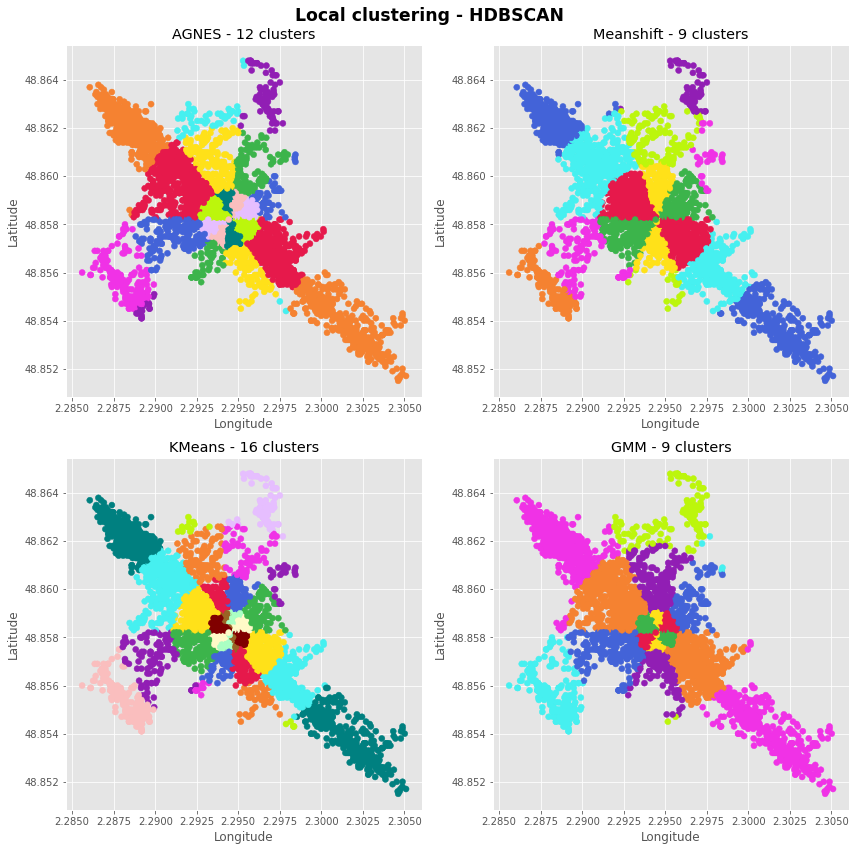

In [96]:
cluster_names = ["intersect_clusters_AGNES","intersect_clusters_Meanshift","intersect_clusters_KMeans","intersect_clusters_GMM"]
display_local(cluster_names, df, "HDBSCAN", False, True)

In [33]:
cluster_names = ["label_Distance_AGNES","label_Distance_Meanshift","label_Distance_KMeans","label_Distance_GMM"]
get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "Distance")

,Distance_AGNES,Distance_Meanshift,Distance_KMeans,Distance_GMM,strat,best
WGSS,0.134266,0.134825,0.134280,0.133912,max,Distance_Meanshift
Ball Hall,0.000018,0.000022,0.000016,0.000016,max,Distance_Meanshift
Banfeld Raftery,-162865.114245,-158019.046977,-165310.240956,-164464.781635,min,Distance_KMeans
Silhouette,0.388452,0.486748,0.295060,0.319204,max,Distance_Meanshift


##### Global comparison

In [49]:
df = srm_dict["2Clust_HDBSCAN_score"].new_df
indices = [WGSS, Ball_hall, Banfeld_Raftery, silhouette_score, davies_bouldin_score, calinski_harabasz_score]
indice_names = ["WGSS", "Ball Hall", "Banfeld Raftery", "Silhouette", "Davies Bouldin", "Calinski Harabasz"]
indice_strats = [np.argmax, np.argmax, np.argmin, np.argmax, np.argmin, np.argmax]
indice_strat_name = ["max", "max", "min", "max", "min", "max"]

In [50]:
cluster_names = ["Clusters", "Clusters_AGNES", "Clusters_KMeans","Clusters_Meanshift", "Clusters_GMM"]
df_HDBSCAN = get_scores(df, cluster_names, indices, indice_names, indice_strats, indice_strat_name, "HDBSCAN")
df_HDBSCAN

,HDBSCAN,HDBSCAN_AGNES,HDBSCAN_KMeans,HDBSCAN_Meanshift,HDBSCAN_GMM,strat,best
WGSS,0.166602,0.139765,0.138022,0.139030,0.138722,max,HDBSCAN
Ball Hall,0.000011,0.000011,0.000011,0.000011,0.000011,max,HDBSCAN
Banfeld Raftery,-193974.001207,-217908.144684,-220400.932741,-213130.039334,-219094.565389,min,HDBSCAN_KMeans
Silhouette,0.191140,-0.009479,0.001949,0.006766,-0.003527,max,HDBSCAN
Davies Bouldin,0.501908,1.603530,4.120342,0.881090,2.098584,min,HDBSCAN
Calinski Harabasz,4114.600349,4598.831569,4548.650546,4708.605034,4719.258742,max,HDBSCAN_GMM


**RESULTS**

In [54]:
df_dbscan = srm_dict["2Clust_DBSCAN_score"].new_df
df_hdbscan = srm_dict["2Clust_HDBSCAN_score"].new_df 
dfs = [df_dbscan, df_hdbscan]
cluster_names = ["Clusters","Clusters_AGNES","Clusters_Meanshift","Clusters_KMeans","Clusters_GMM"]
coords_mon = srm_dict["2Clust_HDBSCAN_score"].coords_mon

In [55]:
map_names = ["HDBSCAN","HDBSCAN_AGNES","HDBSCAN_Meanshift","HDBSCAN_KMeans","HDBSCAN_GMM","DBSCAN","DBSCAN_AGNES","DBSCAN_Meanshift","DBSCAN_KMeans","DBSCAN_GMM",]
maps = []
for df in dfs:
    for name in cluster_names:
        maps.append(create_complex_map(df, name, coords_mon))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

##### Spot qualification

###### Time of day
La date de prise de vue correspond à l'heure à laquelle la photo a été prise. Elle est extraite de la date EXIF lorsqu'elle est disponible, sinon elle est définie sur l'heure de chargement.

In [32]:
df_time = srm_dict["2Clust_HDBSCAN_score"].new_df

In [34]:
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('Europe/Paris')

sun_rise_list = list()
sun_dusk_list = list()
for _, row in df_time.iterrows():
    time_zone = row["date_taken"]
    latitude = row["latitude"]
    longitude = row["longitude"]

    sun = Sun(latitude , longitude)
    sun_rise = sun.get_local_sunrise_time(time_zone) 
    sun_rise_utc = sun_rise.replace(tzinfo=from_zone)
    sun_rise = sun_rise_utc.astimezone(to_zone)
    sun_rise_list.append(sun_rise)

    sun_dusk = sun.get_local_sunset_time(time_zone) 
    sun_dusk_utc = sun_dusk.replace(tzinfo=from_zone)
    sun_dusk = sun_dusk_utc.astimezone(to_zone)
    sun_dusk_list.append(sun_dusk)
        
df_time["Sunrise"] = sun_rise_list
df_time["Sundusk"] = sun_dusk_list

df_time.loc[:,"date_taken"] = df_time.date_taken.apply(lambda x: x.replace(tzinfo=tz.gettz('Europe/Paris')))

OSError: [Errno 22] Invalid argument

Definition of 4 periods:
- sunrise (+- 10 min)
- day
- sundusk (+- 20 min)
- night

In [ ]:
day_time_list = list()
for _, x in df_time.iterrows():
    if (x.date_taken > x.Sunrise - timedelta(minutes=20)) & (x.date_taken < x.Sunrise + timedelta(minutes=20)):
        day_time_list.append("Sunrise")
    elif (x.date_taken > x.Sundusk - timedelta(minutes=20)) & (x.date_taken < x.Sundusk + timedelta(minutes=20)):
        day_time_list.append("Sundusk")
    elif (x.date_taken > x.Sunrise + timedelta(minutes=20)) & (x.date_taken < x.Sundusk - timedelta(minutes=20)):
        day_time_list.append("Day")
    else:
        day_time_list.append("Night")
df_time["TimeOfDay"] = day_time_list

In [ ]:
plt.figure(figsize=(25,7))
plt.pie(x=[(10/144)*20, (10/144)*8*60, (10/144)*40, (10/144)*15*60], labels=["Sunrise", "Day", "Sundusk", "Night"], startangle=180, autopct='%1.1f%%')
plt.ylabel("")
plt.title("Repartition of TimeOfDay")
plt.show()

In [ ]:
plt.figure(figsize=(25,7))
df_time.TimeOfDay.value_counts(normalize=True).plot.pie(startangle=180, autopct='%1.1f%%')
plt.ylabel("")
plt.title("Repartition of TimeOfDay")
plt.show()

In [ ]:
df_time.Clusters_Meanshift.nunique()

In [ ]:
indexes = df_time.Clusters_Meanshift.value_counts()[df_time.Clusters_Meanshift.value_counts()>25].index

In [ ]:
df_time_sup_25 = df_time[df_time.Clusters_Meanshift.isin(indexes)]
df_time_sup_25.Clusters_Meanshift.nunique()

In [ ]:
fig, axes = plt.subplots(df_time_sup_25.Clusters_Meanshift.nunique(), 1, figsize=(5,4*df_time_sup_25.Clusters_Meanshift.nunique()))
for i, cluster in enumerate(df_time_sup_25.Clusters_Meanshift.unique()):
    df = df_time_sup_25[df_time_sup_25.Clusters_Meanshift == cluster]
    df.TimeOfDay.value_counts(normalize=True).plot.pie(startangle=180, autopct='%1.1f%%', ax = axes[i])
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].set_ylabel("")
fig.suptitle("Repartition of TimeOfDay")
fig.tight_layout()
fig.show()

###### Popularity

In [ ]:
popu_df = srm_dict["2Clust_HDBSCAN_score"].new_df[["latitude","longitude","Clusters_Meanshift"]]
pop_df = popu_df.Clusters_Meanshift.value_counts()/popu_df.shape[0]
pop_df = pop_df[:15]
pop_df

In [ ]:
pop_df = pd.DataFrame(pop_df)
pop_df["Rank"] = range(1,pop_df.shape[0]+1)

In [ ]:
popu_df = popu_df[popu_df.Clusters_Meanshift.isin(pop_df.index)]

In [ ]:
popu_df[popu_df.Clusters_Meanshift.isin(pop_df.index)]

###### Panorama

In [ ]:
df_panorama = srm_dict["2Clust_HDBSCAN_score"].new_df

In [ ]:
int_df = pd.merge(df_panorama[["longitude","latitude","Clusters_Meanshift", "aperture_value", "focal_length"]], 
                  dataset[dataset.title != "Eiffel Tower"][["title","longitude","latitude", "aperture_value", "focal_length"]], 
                  how='inner',
                  on=['longitude', 'latitude'])
int_df = int_df.groupby("Clusters_Meanshift").agg({"title": pd.Series.nunique}).reset_index()
int_df.rename({"title":"n_title"}, axis=1, inplace = True)
df_panorama = pd.merge(df_panorama, 
                   int_df, 
                   how='inner',
                   on=['Clusters_Meanshift'])

In [ ]:
pd.DataFrame(df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)).head(30)

In [ ]:
pan = 100*df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)/df_panorama.groupby("Clusters_Meanshift").n_title.sum().sum()
pan

In [ ]:
selected_clusters = list(pd.DataFrame(df_panorama.groupby("Clusters_Meanshift").n_title.sum().sort_values(ascending=False)).head(30).index)

In [ ]:
selected_clusters_df = df_panorama[df_panorama.Clusters_Meanshift.isin(selected_clusters)]

In [ ]:
selected_clusters_df.Clusters_Meanshift.unique()

In [ ]:
pd.DataFrame(selected_clusters_df.groupby("Clusters_Meanshift").aperture_value.mean()).sort_values(by="aperture_value")

In [ ]:
pd.DataFrame(selected_clusters_df.groupby("Clusters_Meanshift").focal_length.mean()).sort_values(by="focal_length")

In [ ]:
df_panorama = df_panorama[df_panorama.Clusters_Meanshift.isin(pan[:25].index)]